In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Load image

In [2]:
filename = "cuboid-sphere.png"

(520, 1239, 3)


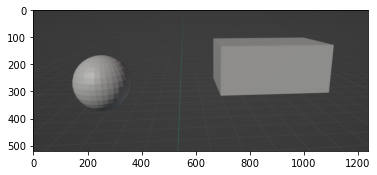

In [3]:
image = cv2.imread(filename)
image_gsk = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

print(image.shape)
plt.imshow(image)
plt.show()

### Maxpool, minpool functionality 

- Grabbed from https://numbersmithy.com/2d-and-3d-pooling-using-numpy/
- I more like to use torch, but here prefer numpy to reduce dependencies

In [4]:
def asStride(arr, sub_shape, stride):
    '''Get a strided sub-matrices view of an ndarray.
    Args:
        arr (ndarray): input array of rank 2 or 3, with shape (m1, n1) or (m1, n1, c).
        sub_shape (tuple): window size: (m2, n2).
        stride (int): stride of windows in both y- and x- dimensions.
    Returns:
        subs (view): strided window view.
    See also skimage.util.shape.view_as_windows()
    '''
    s0, s1 = arr.strides[:2]
    m1, n1 = arr.shape[:2]
    m2, n2 = sub_shape[:2]
    view_shape = (1+(m1-m2)//stride, 1+(n1-n2)//stride, m2, n2)+arr.shape[2:]
    strides = (stride*s0, stride*s1, s0, s1)+arr.strides[2:]
    subs = np.lib.stride_tricks.as_strided(
        arr, view_shape, strides=strides, writeable=False)
    return subs

def poolingOverlap(mat, f, stride=None, method='max', pad=False,
                   return_max_pos=False):
    '''Overlapping pooling on 2D or 3D data.
    Args:
        mat (ndarray): input array to do pooling on the first 2 dimensions.
        f (int): pooling kernel size.
    Keyword Args:
        stride (int or None): stride in row/column. If None, same as <f>,
            i.e. non-overlapping pooling.
        method (str): 'max for max-pooling,
                      'mean' for average-pooling.
        pad (bool): pad <mat> or not. If true, pad <mat> at the end in
               y-axis with (f-n%f) number of nans, if not evenly divisible,
               similar for the x-axis.
        return_max_pos (bool): whether to return an array recording the locations
            of the maxima if <method>=='max'. This could be used to back-propagate
            the errors in a network.
    Returns:
        result (ndarray): pooled array.
    See also unpooling().
    '''
    m, n = mat.shape[:2]
    if stride is None:
        stride = f
    _ceil = lambda x, y: x//y + 1
    if pad:
        ny = _ceil(m, stride)
        nx = _ceil(n, stride)
        size = ((ny-1)*stride+f, (nx-1)*stride+f) + mat.shape[2:]
        mat_pad = np.full(size, 0)
        mat_pad[:m, :n, ...] = mat
    else:
        mat_pad = mat[:(m-f)//stride*stride+f, :(n-f)//stride*stride+f, ...]
    view = asStride(mat_pad, (f, f), stride)
    if method == 'max':
        result = np.nanmax(view, axis=(2, 3), keepdims=return_max_pos)
    if method == 'min':
        result = np.nanmin(view, axis=(2, 3), keepdims=return_max_pos)
    if method == 'mean':
        result = np.nanmean(view, axis=(2, 3), keepdims=return_max_pos)
    if return_max_pos:
        pos = np.where(result == view, 1, 0)
        result = np.squeeze(result)
        return result, pos
    else:
        return result

### Remove mesh

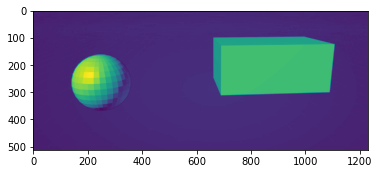

In [5]:
_image = poolingOverlap(image_gsk, 5, 1, 'min')
_image = poolingOverlap(_image, 5, 1, 'max')
plt.imshow(_image)

### Sharpen image

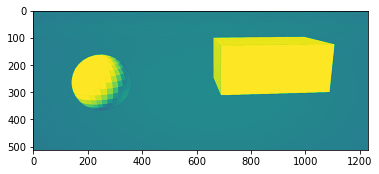

In [6]:
kernel = np.array([[-1, -1, -1], [-1, 10, -1], [-1, -1, -1]])
_image = cv2.filter2D(_image, -1, kernel)
plt.imshow(_image)

### Highlight all background and minpool to make objects easy separatable

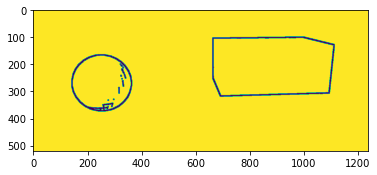

In [7]:
ret, _image_thresh = cv2.threshold(_image, 90, 255, cv2.THRESH_BINARY)
_image_thresh = poolingOverlap(_image_thresh, 5, 1, 'min')

# Pad to compensat size reduction on pooling
_image_thresh = cv2.copyMakeBorder(_image_thresh, 6, 6, 6, 6, cv2.BORDER_DEFAULT)
plt.imshow(_image_thresh)
plt.show()

### Make foreground mask

In [8]:
_, _labels, _, _ = cv2.connectedComponentsWithStats(_image_thresh, 4, cv2.CV_32S)

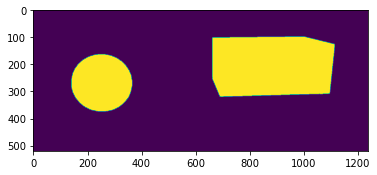

In [9]:
foreground_mask = (np.ones_like(_labels) - (_labels == 1)).astype('uint8')
plt.imshow(foreground_mask)

### Separate objects

In [10]:
_, obj_labels, _, _ = cv2.connectedComponentsWithStats(foreground_mask, 4, cv2.CV_32S)

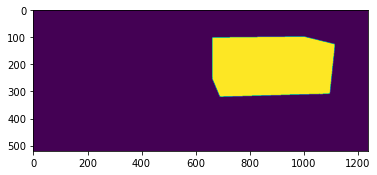

In [11]:
cuboid_object = obj_labels == 1
plt.imshow(cuboid_object)

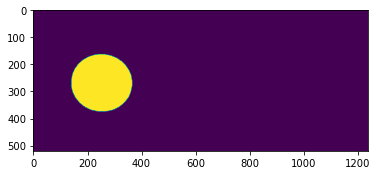

In [12]:
sphere_object = obj_labels == 2
sphere_object = sphere_object.astype('uint8')
plt.imshow(sphere_object)

### Get main face of cuboid

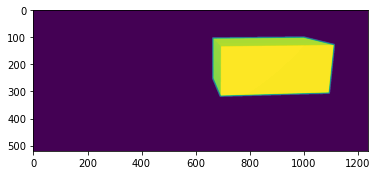

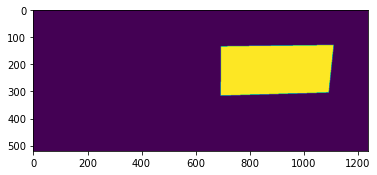

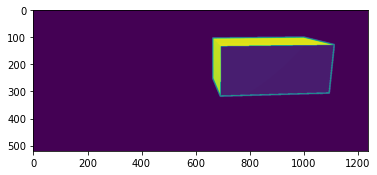

In [13]:
face = image_gsk * cuboid_object

plt.imshow(face)
plt.show()

main_face = (face>130).astype('uint8')
plt.imshow(main_face)
plt.show()

plt.imshow(face - main_face*130)
plt.show()

# Sphere edges and area

Sphere area= 37612


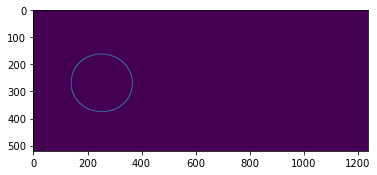

In [14]:
sphere_object_mp = poolingOverlap(sphere_object, 3, 1)
sphere_object_mp = cv2.copyMakeBorder(sphere_object_mp, 1, 1, 1, 1, cv2.BORDER_DEFAULT)

sphere_object_edges = sphere_object_mp - sphere_object
plt.imshow(sphere_object_edges)

sphere_area_pixels = np.sum(sphere_object)
print('Sphere area=', sphere_area_pixels)

# Cuboid main face edges and area

Cuboid main face area= 72852


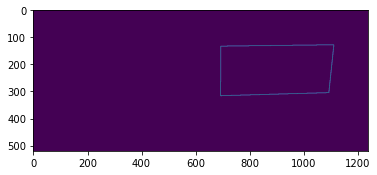

In [15]:
main_face_mp = poolingOverlap(main_face, 3, 1)
main_face_mp = cv2.copyMakeBorder(main_face_mp, 1, 1, 1, 1, cv2.BORDER_DEFAULT)

main_face_edges = main_face_mp - main_face
plt.imshow(main_face_edges)

main_face_area_pixels = np.sum(main_face)
print('Cuboid main face area=', main_face_area_pixels)